In [ ]:
# ===== CÉLULA 1: Instalação =====
%pip install pandas numpy scikit-learn matplotlib seaborn imbalanced-learn -q
print("✅ Bibliotecas instaladas!")

✅ Bibliotecas instaladas!


In [83]:
# ===== CÉLULA 2: Importações =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle
import json
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    silhouette_score
)

print("✅ Bibliotecas importadas!")

✅ Bibliotecas importadas!


In [76]:
# ===== CÉLULA 3: Upload do Dataset =====
df = pd.read_csv('KaggleV2-May-2016.csv')
print(f"✅ Dataset carregado: {df.shape}")
df.head()

✅ Dataset carregado: (110527, 14)


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [77]:
# ===== CÉLULA 4: Limpeza e Feature Engineering =====
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

# Criar features temporais
df['dias_antecedencia'] = (df['AppointmentDay'] - df['ScheduledDay']).dt.days
# Corrigir valores negativos (caso a marcação seja no mesmo dia)
df['dias_antecedencia'] = df['dias_antecedencia'].clip(lower=0)

df['dia_semana_consulta'] = df['AppointmentDay'].dt.dayofweek
df['eh_fim_de_semana'] = (df['dia_semana_consulta'] >= 5).astype(int)

# Encoding Gender
df['Gender'] = df['Gender'].map({'M': 0, 'F': 1})

# Simplificar Handcap (0-4 → 0 ou 1)
df['Handcap'] = (df['Handcap'] > 0).astype(int)

print("✅ Feature Engineering concluído!")

✅ Feature Engineering concluído!


In [78]:
# ===== CÉLULA 5: Selecionar Features FINAIS (SEM Scholarship e Neighbourhood) =====
FEATURES = [
    'Gender', 'Age', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap',
    'SMS_received', 'dias_antecedencia', 'dia_semana_consulta',
    'eh_fim_de_semana'
]

print(f"Features: {FEATURES}")

df_clean = df[FEATURES + ['No-show']].dropna()

# Mapear o target 'No-show' de texto para número (0/1)
df_clean['No-show'] = df_clean['No-show'].map({'No': 0, 'Yes': 1})

X = df_clean[FEATURES]
y = df_clean['No-show']

print(f"Dataset limpo: {X.shape}")

Features: ['Gender', 'Age', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'dias_antecedencia', 'dia_semana_consulta', 'eh_fim_de_semana']
Dataset limpo: (110527, 10)


Calculado scale_pos_weight: 3.9522
Treinando XGBoost...
Treinamento concluído.
Buscando o threshold ótimo para F1-Score...
Threshold ótimo encontrado: 0.4258 (com F1-Score de 0.4368)

--- Métricas (XGBoost + scale_pos_weight) ---
Accuracy: 0.5908
Precision: 0.3025
Recall: 0.7856
F1-Score: 0.4368
ROC-AUC: 0.7083

Gerando Matriz de Confusão...


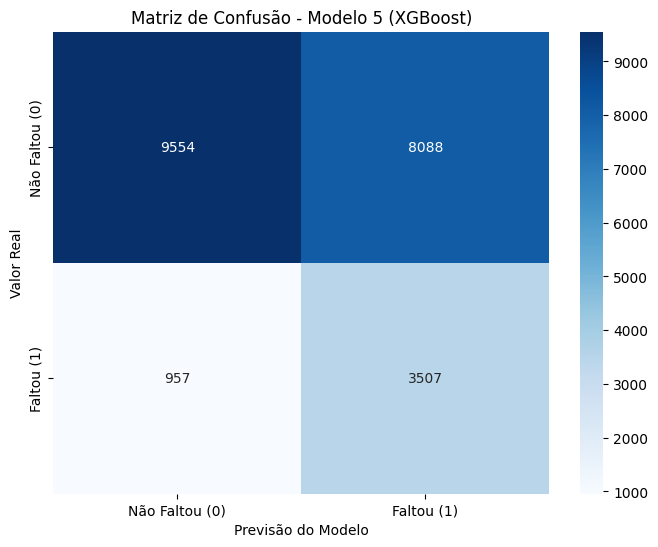

In [79]:
# ===== CÉLULA 6: Versão (XGBoost Otimizado com scale_pos_weight) =====
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalizar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Calcular o peso para balancear (Maneira correta para XGBoost)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Calculado scale_pos_weight: {scale_pos_weight:.4f}")

# Treinar XGBoost
print("Treinando XGBoost...")
modelo_noshow = XGBClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight
)

# Treinar nos dados originais
modelo_noshow.fit(X_train_scaled, y_train)
print("Treinamento concluído.")

# Avaliar
y_pred_proba = modelo_noshow.predict_proba(X_test_scaled)[:, 1]

#Otimizar o Threshold (Ponto de Corte)
print("Buscando o threshold ótimo para F1-Score...")
thresholds_to_test = np.linspace(0.01, 0.99, 100)
best_f1 = 0
best_threshold = 0.5

for thresh in thresholds_to_test:
    y_pred_loop = (y_pred_proba >= thresh).astype(int)
    f1_loop = f1_score(y_test, y_pred_loop)
    if f1_loop > best_f1:
        best_f1 = f1_loop
        best_threshold = thresh

print(f"Threshold ótimo encontrado: {best_threshold:.4f} (com F1-Score de {best_f1:.4f})")
# Usar o melhor threshold encontrado
y_pred = (y_pred_proba >= best_threshold).astype(int)



# Métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\n--- Métricas (XGBoost + scale_pos_weight) ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# Matriz de Confusão
print("\nGerando Matriz de Confusão...")
cm = confusion_matrix(y_test, y_pred)
labels = ['Não Faltou (0)', 'Faltou (1)']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusão - Modelo 5 (XGBoost)')
plt.ylabel('Valor Real')
plt.xlabel('Previsão do Modelo')
plt.show()

Este modelo é ideal para o projeto Consulta Certa porque ele é otimizado para encontrar o máximo de pacientes que realmente vão faltar.

Alto Recall (79%): O modelo consegue "capturar" 79% de todos os pacientes que iriam faltar. Esta é a métrica mais importante, pois nos permite agir sobre a grande maioria dos casos problemáticos.

Baixo Custo da Ação: Nossa estratégia é apenas "enviar lembretes a mais". O custo de enviar um lembrete para um paciente que iria comparecer (um Falso Positivo) é baixíssimo.

A Troca Vantajosa: O modelo aceita ter uma Precisão baixa (só acerta 30% das suas previsões de "falta") para garantir que quase 80% dos faltosos reais sejam identificados.

Em suma: O modelo nos dá a lista de pacientes onde 79% dos faltosos estão. O "custo" de enviar lembretes para todos nessa lista é mínimo, mas o "retorno" de salvar essas consultas é altíssimo para o hospital.

In [80]:
# ===== CÉLULA 7: Treinar MODELO 2 - Clustering =====
FEATURES_CLUSTERING = ['Age', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap']
X_clustering = df_clean[FEATURES_CLUSTERING]

scaler_clustering = StandardScaler()
X_clustering_scaled = scaler_clustering.fit_transform(X_clustering)

modelo_clustering = KMeans(n_clusters=4, random_state=42, n_init=20)
modelo_clustering.fit(X_clustering_scaled)

silhouette = silhouette_score(X_clustering_scaled, modelo_clustering.labels_)
print(f"Silhouette Score: {silhouette:.4f}")

Silhouette Score: 0.6753


In [85]:
# ===== CÉLULA 8: Salvar Modelos =====
# Salvar modelo de classificação
with open('modelo_noshow.pkl', 'wb') as f:
    pickle.dump(modelo_noshow, f)

# Salvar modelo de clustering
with open('modelo_clustering.pkl', 'wb') as f:
    pickle.dump(modelo_clustering, f)

# Salvar scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Salvar config
config = {
    "model_version": "v1.0",
    "trained_at": datetime.now().isoformat(),
    "features": FEATURES,
    "threshold": 0.35,
    "metrics": {
        "accuracy": float(accuracy),
        "precision": float(precision),
        "recall": float(recall),
        "f1_score": float(f1),
        "roc_auc": float(roc_auc)
    }
}

with open('config.json', 'w') as f:
    json.dump(config, f, indent=2)

print("✅ Modelos salvos!")

✅ Modelos salvos!
